##  Load and Clean the EEG Data


In [12]:
import pandas as pd
import numpy as np

# Load the EEG data using pandas
filename = 'OpenBCI-RAW-2024-08-23_17-26-02.txt'

# Read the data, skipping metadata and extracting only numeric columns
data = pd.read_csv(filename, delimiter=',', skiprows=4)

# Drop any non-numeric columns like 'Sample Index'
numeric_data = data.select_dtypes(include=[np.number])

# Convert the cleaned DataFrame to NumPy array for further processing
eeg_data = numeric_data.to_numpy()

# Check the shape and a few rows to ensure it's loaded correctly
print("EEG data shape:", eeg_data.shape)
print("First 5 rows of EEG data:", eeg_data[:5])


EEG data shape: (30640, 24)
First 5 rows of EEG data: [[ 6.00000000e+00 -1.51227656e+04 -1.21601067e+05 -1.76921568e+05
  -1.87500022e+05 -1.87500022e+05 -1.87500022e+05 -1.87500022e+05
  -1.87500022e+05  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.92000000e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.72441416e+09  0.00000000e+00]
 [ 7.00000000e+00 -1.65937563e+04 -1.22209862e+05 -1.77613108e+05
  -1.87500022e+05 -1.87500022e+05 -1.87500022e+05 -1.87500022e+05
  -1.87500022e+05  9.40000000e-02 -1.01000000e+00 -2.40000000e-02
   1.92000000e+02  2.00000000e+00  2.40000000e+02  2.24000000e+02
   1.12000000e+02  2.55000000e+02  6.40000000e+01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.72441416e+09  0.00000000e+00]
 [ 8.00000000e+00 -2.14763160e+04 -1.23807095e+05 -1.79263181e+05
  -1.87500022e+05 -1.87500022e+05 -1.87500022e+05 -1.87500022e+05
  -1.87500022e+05  9

##  Preprocess the EEG Data (Bandpass Filter)

In [13]:
from scipy.signal import butter, filtfilt

# Define a bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Apply the bandpass filter to the data
def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data, axis=0)

# Set parameters
sampling_rate = 256  # Example sampling rate, adjust accordingly
lowcut = 0.5  # Hz
highcut = 50  # Hz

# Apply bandpass filter
filtered_eeg = apply_bandpass_filter(eeg_data, lowcut, highcut, sampling_rate)
print("Filtered EEG data shape:", filtered_eeg.shape)


Filtered EEG data shape: (30640, 24)


### Perform FFT and Spectral Analysis

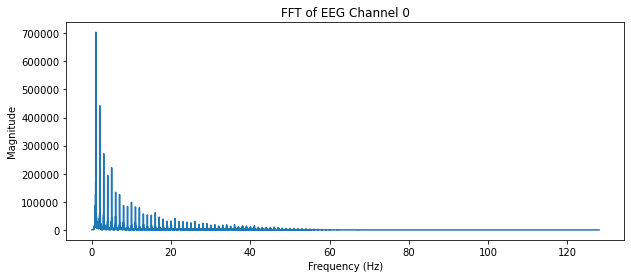

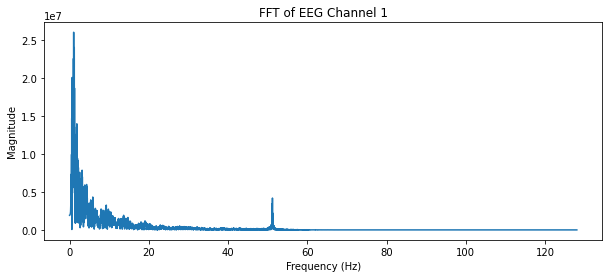

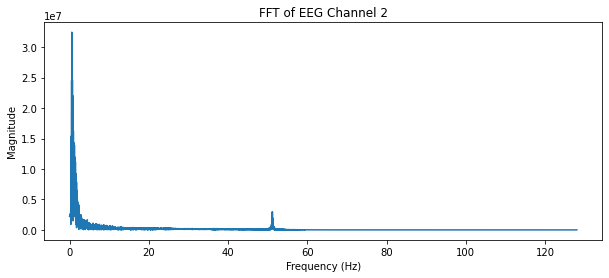

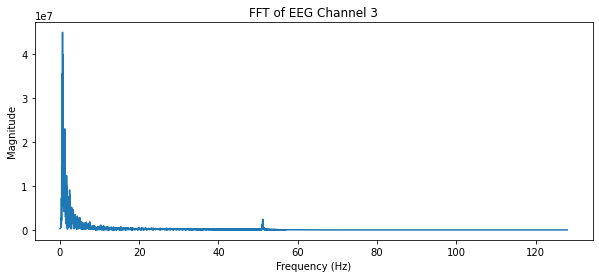

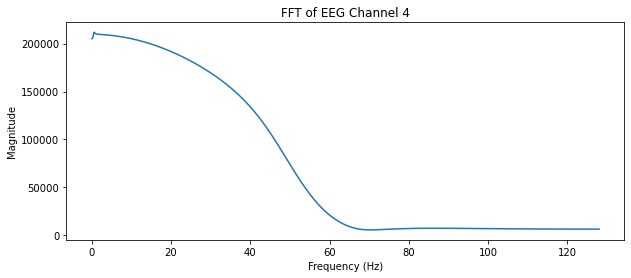

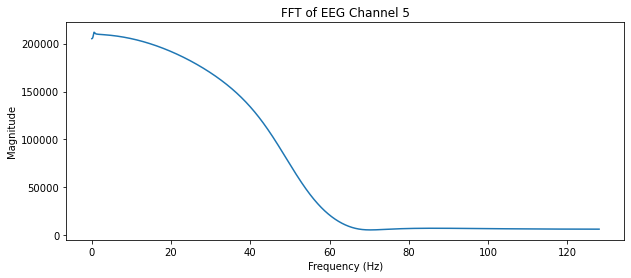

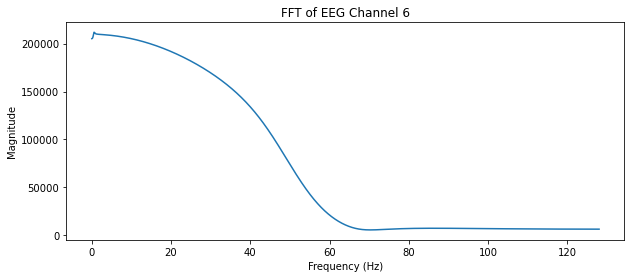

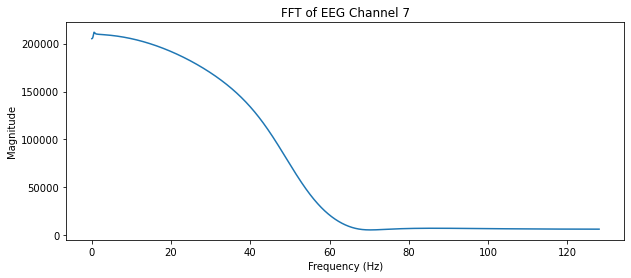

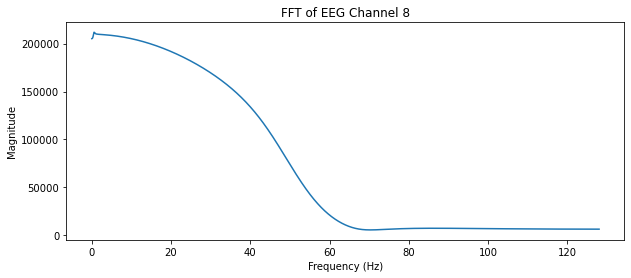

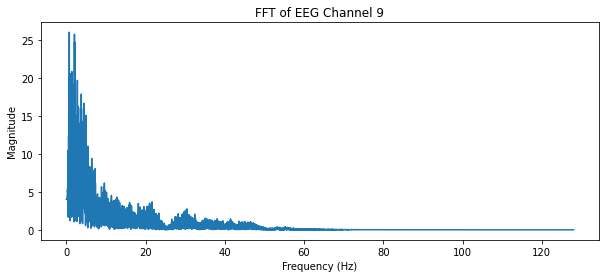

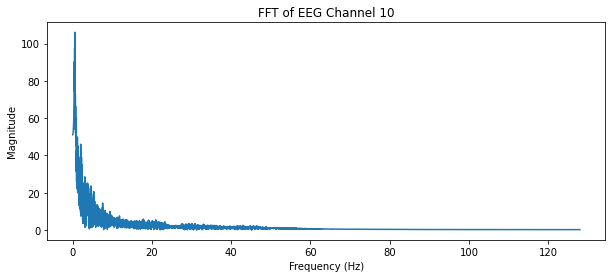

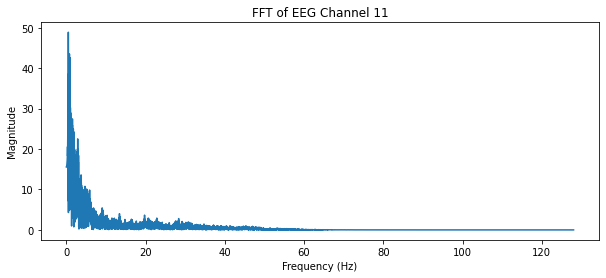

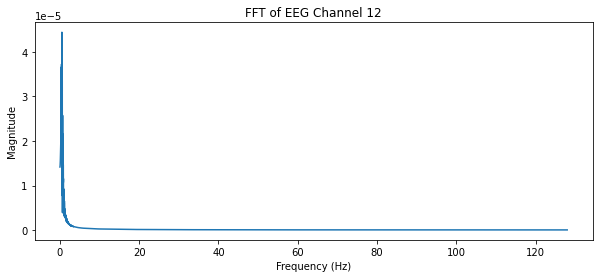

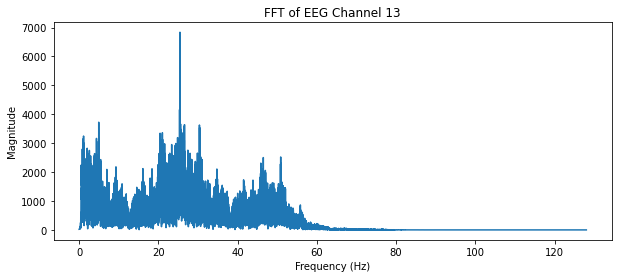

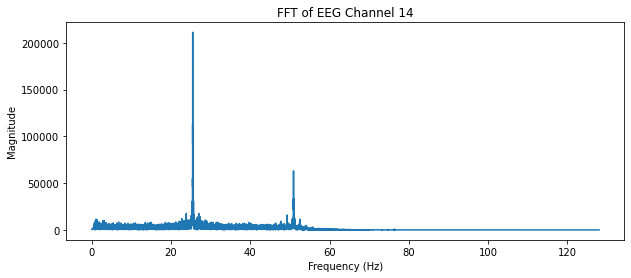

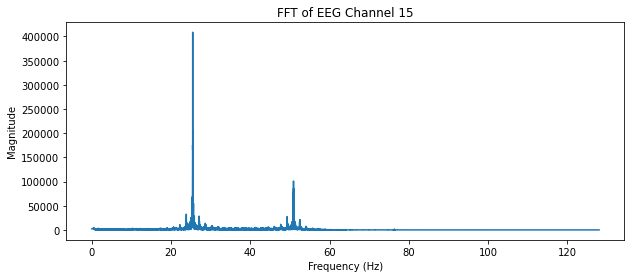

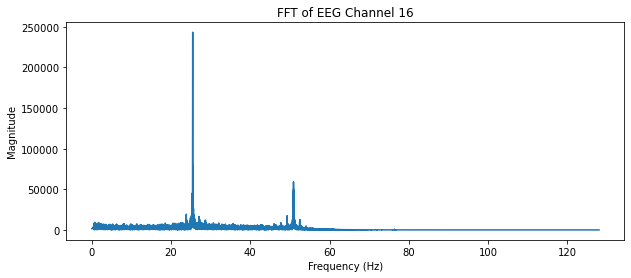

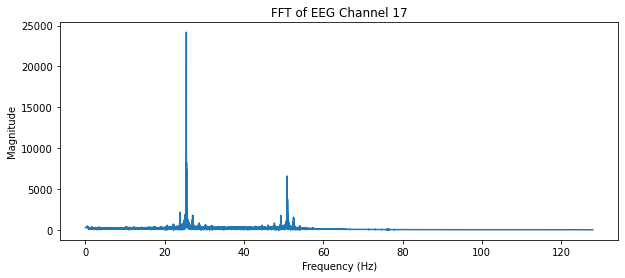

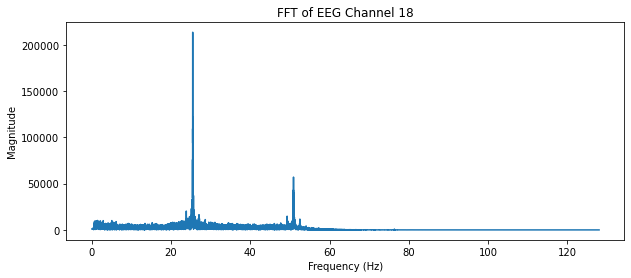

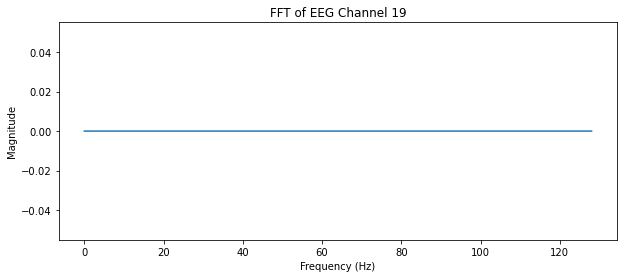

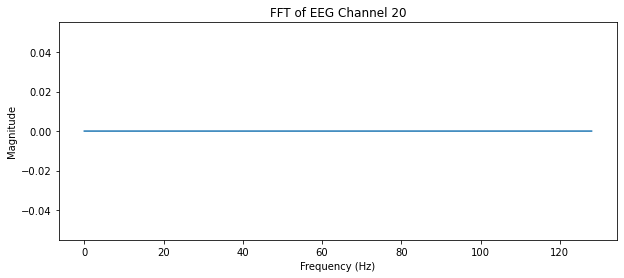

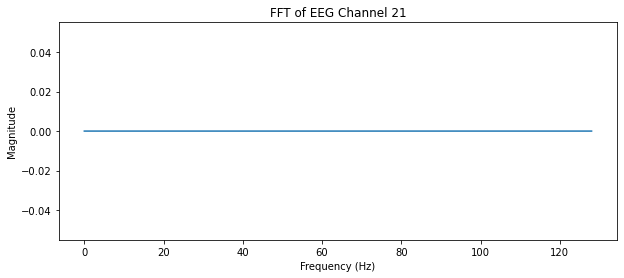

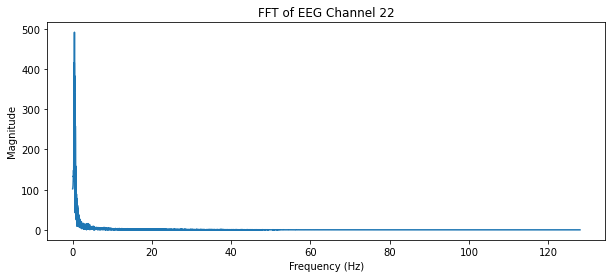

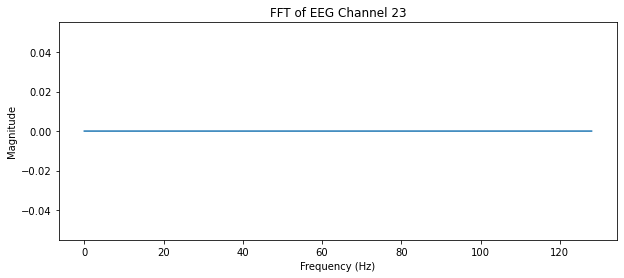

In [14]:
import matplotlib.pyplot as plt

# Compute FFT
def compute_fft(data, fs):
    n = len(data)
    freqs = np.fft.fftfreq(n, 1/fs)
    fft_values = np.fft.fft(data)
    fft_magnitude = np.abs(fft_values)
    return freqs[:n // 2], fft_magnitude[:n // 2]  # Return only positive frequencies

# Perform FFT for each channel (column)
for channel in range(filtered_eeg.shape[1]):
    freqs, fft_magnitude = compute_fft(filtered_eeg[:, channel], sampling_rate)
    
    # Plot the FFT for each channel
    plt.figure(figsize=(10, 4))
    plt.plot(freqs, fft_magnitude)
    plt.title(f'FFT of EEG Channel {channel}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.show()


# Feature Extraction (Band Power)

In [15]:
# Define a function to calculate power in specific frequency bands
def bandpower(data, freqs, low, high):
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return np.mean(data[idx_band])

# Define the EEG bands
bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 50)}

# Extract power in each band for each EEG channel
features = []
for channel in range(filtered_eeg.shape[1]):
    freqs, fft_magnitude = compute_fft(filtered_eeg[:, channel], sampling_rate)
    feature_vector = []
    for band_name, (low, high) in bands.items():
        power = bandpower(fft_magnitude, freqs, low, high)
        feature_vector.append(power)
    features.append(feature_vector)

# Convert to NumPy array for use in machine learning
features = np.array(features)
print("Extracted features shape:", features.shape)


Extracted features shape: (24, 5)


## Labeling and Machine Learning

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Example labels: 0 for relaxed, 1 for stressed (adjust based on your data)
labels = np.array([0, 1, 0])  # Modify based on your data intervals

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy * 100:.2f}%")


ValueError: Found input variables with inconsistent numbers of samples: [24, 3]